In [2]:
import os
import time
import re
import numpy as np
import math
from os import listdir
from os.path import isfile, join

from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as patches
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.gridspec as gridspec

import paramiko
import subprocess

from numba import vectorize
from numba import jit

from scipy.ndimage import imread
from scipy import ndimage
from scipy.ndimage.filters import gaussian_filter
from skimage.morphology import square, disk, dilation

from PIL import Image
import pandas as pd

from utils import read_tiff, make_dir, read_images_from_directory, smooth
#from monitor_utils import *

In [93]:
#---------------------------
#   Colors
#---------------------------

blue = (57 / 255.0, 106 / 255.0, 177 / 255.0)
red = (204/ 255.0, 37/ 255.0, 41/ 255.0 )
green = (62/ 255.0, 150/ 255.0, 81/ 255.0 )  
grey = (128/ 255.0, 133/ 255.0, 133/ 255.0 )
gold = (237/ 255.0, 218/ 255.0, 116/ 255.0 )

#---------------------------
#   Fonts
#---------------------------

title_font_size = 20
label_font_size = 16
ticks_font_size = 16



def read_flow_from_components(file_u, file_v, shape):
    u = np.fromfile(file_u, dtype='float32', sep="")
    u = u.reshape(shape)
    
    v = np.fromfile(file_v, dtype='float32', sep="")
    v = v.reshape(shape)
    
    return u,v

def read_raw_image(file_name, shape):
    img = np.fromfile(file_name, dtype='float32', sep="")
    img = img.reshape(shape)
    
    return img
    

def read_raw_files_save_as_multitiff_stack(path, file_name, shape, mask=""):
    if mask == "":
        files = sorted([f for f in listdir(path) if isfile(join(path, f))])
    else:
        files = sorted([f for f in listdir(path) if isfile(join(path, f)) and f.find(mask) != -1])
        
    #print('Number of images to convert:', len(files))
    
    imlist = []
    for f in files:
        #im = np.array(Image.open(p + f))
        #imlist.append(Image.fromarray(m))

        np_im = read_raw_image(path + f, shape)
        imlist.append(Image.fromarray(np_im))

    imlist[0].save(file_name, save_all=True, append_images=imlist[1:])



def make_analysis_figure(data, measure_name, measure_file):
     
    data = data*vel_factor

    # Setup figure
    fig = plt.figure(1)

    fig.set_size_inches(20/2 + 2, 14, forward=True)
    plt.subplots_adjust(top=0.95, bottom=0.06, left=0.1, right=0.90, hspace=0.3 )

    gs = gridspec.GridSpec(2, 1, height_ratios=[1.3,1])

    #-------------------------------------------
    # Figure 1: Velocity maps
    #-------------------------------------------

    # Setup figure
    ax0 = plt.subplot(gs[0,:])

    imx = ax0.imshow(data, vmin=vel_min, vmax=vel_max, cmap='inferno')
    ax0.set_title('Dataset: '+ dataset +', '+ measure_name, size=title_font_size, y=1.05)    
    ax0.set_xlabel('distance, [mm]', size=label_font_size)
    ax0.set_ylabel('distance, [mm]', size=label_font_size)

    width = data.shape[1]
    x_lables = ['{:.1f}'.format(x) for x in np.arange(0.0, width+1, 100.0) /1000.0*pixel_size]
    
    x_ticks = np.arange(0, width+1, 100)
    ax0.set_xticks(x_ticks)
    ax0.set_xticklabels(x_lables, fontsize = ticks_font_size)

    height = data.shape[0]

    
    y_lables = ['{:.1f}'.format(x) for x in np.arange(0.0, height+1, 100.0) /1000.0*pixel_size]
    y_ticks = np.arange(0, height+1, 100)
    ax0.set_yticks(y_ticks)
    ax0.set_yticklabels(y_lables)

    ax0.yaxis.set_tick_params(labelsize=label_font_size)

    axins0 = inset_axes(ax0,
                       width="1.5%",  # width = 10% of parent_bbox width
                       height="100%",  # height : 50%
                       loc=3,
                       bbox_to_anchor=(1.02, 0., 1, 1),
                       bbox_transform=ax0.transAxes,
                       borderpad=0                    
                       )

    # Separation lines between combined images
    clb = plt.colorbar(imx, cax=axins0)
    clb.ax.tick_params(labelsize=ticks_font_size)
    
    step = int(width / 4)

    ax0.axvline(step*1,linewidth=2, color=blue, alpha=0.7)
    ax0.axvline(step*2,linewidth=2, color=red, alpha=0.7)
    ax0.axvline(step*3,linewidth=2, color=green, alpha=0.7)


    # Create a Rectangle patch
    rect1 = patches.Rectangle((step*1 - rx, height/2-ry),2*rx,2*ry,linewidth=1, linestyle='--',edgecolor=blue,facecolor='none', alpha=1.0)
    ax0.add_patch(rect1)

    rect2 = patches.Rectangle((step*2 - rx, height/2-ry),2*rx,2*ry,linewidth=1, linestyle='--',edgecolor=red,facecolor='none', alpha=1.0)
    ax0.add_patch(rect2)

    rect3 = patches.Rectangle((step*3 - rx, height/2-ry),2*rx,2*ry,linewidth=1, linestyle='--',edgecolor=green,facecolor='none', alpha=1.0)
    ax0.add_patch(rect3)

    ax0.grid(False)


    #-------------------------------------------
    # Figure 2: Velocity profiles
    #-------------------------------------------
    
    if plot_profiles:

        plt.style.use('seaborn')

        #fig.set_size_inches(25, 8, forward=True)
        #plt.subplots_adjust(left=0.05, right=0.95, wspace=0.1)

        smooth_mask = 4
        avg_width = 2
         
        #num_points = 7
        #
        #if region == '0': 
        #    offset = 300 # Manuall offset for the Tile 0
        #else:
        #    image_width = width*pixel_size / 1000 # in mm
        #    shift = 2.5 # in mm
        #    offset = int((image_width - shift) * 1000 / pixel_size) # in pixels
        #    offset = 50
#
        #print('Offset:', offset)
        #
        ## Profiles along spraying direction
        #for i in range(0, int((width-offset)/step_in_pixels)):
        #    
        #    x = int(offset + step_in_pixels*i)
        #    
        #    ax0.axvline(x,linewidth=1, color=grey, alpha=1.0)
        #    
        #    vels = []
        #    
        #    for p in range(num_points):
        #        
        #        y = int(height / (num_points + 1) * (p+1))
        #        
        #        rect = patches.Rectangle((x - px, y-py),2*px,2*py,linewidth=1,edgecolor=blue,facecolor='none', alpha=1.0)
        #        ax0.add_patch(rect)
        #        
        #        vel_patch_mean =  np.mean(data[y-py:y+py, x-px:x+px])
        #        vels.append(vel_patch_mean)
        #    
        #    #print(vels)
      
        
        # Subplot 2  
        
        vel_profile_1 = np.mean(data[:,step*1-avg_width:step*1+avg_width], axis=1)
        vel_profile_2 = np.mean(data[:,step*2-avg_width:step*2+avg_width], axis=1)
        vel_profile_3 = np.mean(data[:,step*3-avg_width:step*3+avg_width], axis=1)
        


        #np.savetxt(results_path + '_vel_profile_A.txt', vel_profile_1, fmt='%.5f')
        #np.savetxt(results_path + '_vel_profile_B.txt', vel_profile_2, fmt='%.5f')
        #np.savetxt(results_path + '_vel_profile_C.txt', vel_profile_3, fmt='%.5f')

        ax1 = plt.subplot(gs[1,0])
        ax1.set_title('spray region: '+region, size=title_font_size)

        ax1.plot(smooth(vel_profile_1, smooth_mask, 'flat'), linewidth=1.5, color=blue)
        ax1.plot(smooth(vel_profile_2, smooth_mask, 'flat'), linewidth=1.5, color=red)
        ax1.plot(smooth(vel_profile_3, smooth_mask, 'flat'), linewidth=1.5, color=green)
        
        ax1.set_ylim(vel_min, vel_max)
        ax1.set_ylabel('velocity, [m\s]', size=label_font_size)
        ax1.set_xlabel('distance, [mm]', size=label_font_size)
        ax1.set_xticks(y_ticks)
        ax1.set_xticklabels(y_lables, fontsize = ticks_font_size)
        ax1.yaxis.set_tick_params(labelsize=label_font_size)
        
    
    #all_results_path = 'y:\\projects\\pn-reduction\\2018_03_esrf_mi1325\\Phantom\\Glasduese\\analysis_all_results\\'

    fig.savefig(results_path + dataset + '_fig_'+ measure_file +'.png')
    #fig.savefig(all_results_path + region + '\\' + d + '_' + dataset + '_' + region + '_comb_'+ measure_file +'_fig.png')


    #-------------------------------------------
    # Summary results table
    #-------------------------------------------

    #res = [date, dataset, region, avg_vel_A, std_vel_A, avg_vel_B, std_vel_B, avg_vel_C, std_vel_C]

    #df.loc[len(df)] = res
    #results_table.append(res)

    clb.remove()
    plt.draw()
    
    if show_plot:
        plt.show()

          
def count_zero(a):  
    eps = 1e-5
    #vals = a[a < eps]
    vals = np.where(a < min_vel_in_pixels, 1, 0)
    
    if len(vals) == 0:
        return 0.0
    else:
        return np.sum(vals)
   
def max_outliers(a):  
    eps = 1e-5
    #vals = a[a < eps]
    vals = np.where(a > max_vel_in_pixels, a, 0)
    
    if len(vals) == 0:
        return 0.0
    else:
        return np.max(vals)

def high_corr(a):  
    eps = 1e-5
    #vals = a[a < eps]
    vals = np.where(a > min_corr_value, a, 0)
    
    if len(vals) == 0:
        return 0.0
    else:
        return np.mean(vals)
    
def low_corr(a):  
    eps = 1e-5
    #vals = a[a < eps]
    vals = np.where(a < min_corr_value, a, 0)
    
    if len(vals) == 0:
        return 0.0
    else:
        return np.mean(vals)

    
def plot_metrics():
    
    #a = np.array([[0,0,1,3,0], [0,0,1,3,1]])
    corr_max = np.apply_along_axis(high_corr, 0, corr)
    corr_min = np.apply_along_axis(low_corr, 0, corr)

    print(np.mean(corr_min))

    amp_zeros = np.apply_along_axis(count_zero, 0, amp)
    amp_outliers = np.apply_along_axis(max_outliers, 0, amp)
    #print(amp_zeros)

    fig = plt.figure(1)

    fig.set_size_inches(20/3 + 2, 14, forward=True)
    plt.subplots_adjust(top=0.95, bottom=0.06, left=0.1, right=0.90, hspace=0.3 )

    gs = gridspec.GridSpec(4, 1, height_ratios=[1,1,1,1])


    # Setup figure
    ax0 = plt.subplot(gs[0,:])
    imx0 = ax0.imshow(corr_max, cmap='inferno')
    ax0.set_title('Keep correlation, Mean')
    ax0.grid(False)
    plt.colorbar(imx0, ax=ax0)

    ax1 = plt.subplot(gs[1,:])
    imx1 = ax1.imshow(corr_min, cmap='inferno')
    ax1.set_title('Drop correlation, Mean')
    ax1.grid(False)
    plt.colorbar(imx1, ax=ax1)

    ax2 = plt.subplot(gs[2,:])
    imx2 = ax2.imshow(amp_zeros, cmap='inferno')
    ax2.set_title('Low velocity, count')
    ax2.grid(False)
    plt.colorbar(imx2, ax=ax2)

    ax3 = plt.subplot(gs[3,:])
    imx3 = ax3.imshow(amp_outliers, cmap='inferno')
    ax3.set_title('Fast outliers velocity, Max')
    ax3.grid(False)
    plt.colorbar(imx3, ax=ax3)

    plt.show()

    fig.savefig(results_path + dataset + '_metrics_fig.png')
    
def check_data_frames():
    
    fig = plt.figure(1)

    fig.set_size_inches(14, 7, forward=True)
    plt.subplots_adjust(top=0.95, bottom=0.04, left=0.05, right=0.95, hspace=0.3 )

    gs = gridspec.GridSpec(2, 2)
    
    flat1 = images[flats_start]
    ax1 = plt.subplot(gs[0,0])
    ax1.imshow(flat1, cmap='gray')
    ax1.set_title('First flat field. index={}'.format(flats_start))
    plt.grid(False)
    

    flat2 = images[flats_end]
    ax2 = plt.subplot(gs[0,1])
    ax2.imshow(flat2, cmap='gray')
    ax2.set_title('Last flat field. index={}'.format(flats_end))
    plt.grid(False)


    im1 = images[start_spray]
    ax3 = plt.subplot(gs[1,0])
    ax3.imshow(im1, cmap='gray')
    ax3.set_title('First data frame. index={}'.format(start_spray))
    plt.grid(False)
 

    im2 = images[start_spray+seq_length]
    ax4 = plt.subplot(gs[1,1])
    ax4.imshow(im2, cmap='gray')
    plt.grid(False)
    ax4.set_title('Last data frame. index={}'.format(start_spray))
    
    plt.show()
    
    im1 = images[start_spray][y0:y0+h, x0:x0+w]
    plt.grid(False)
    plt.imshow(im1, vmin=30, vmax=150, cmap='gray')
    plt.title('Cropped frame. Input for processing')
    
    plt.show()
    

def summarize_velocity_profiles(measures, df, pos, num_vert_point=5):

    width = measures[0][0].shape[1]
    height = measures[0][0].shape[0]

    if region == '0': 
        offset = 306 # Manuall offset for the Tile 0
    else:
        image_width = width*pixel_size / 1000 # in mm
        shift = 2.5 # in mm
        offset = int((image_width - shift) * 1000 / pixel_size) + int(step_in_pixels / 2)  # in pixels
        
    #print('Offset:', offset)

    # For all measures (filtering constraints). [no, all, corr, peak, amp]
    for m in measures:
        
        data = m[0]
        measure_name = m[1]
        
        # Profiles along spraying direction  
        num_of_profiles = int((width-offset)/step_in_pixels)

        for i in range(0, num_of_profiles+1):

            x = int(offset + step_in_pixels*i)

            #ax.axvline(x,linewidth=1, color=grey, alpha=1.0)

            vels = []

            for p in range(num_vert_point):

                y = int(height / (num_vert_point + 1) * (p+1))

                #rect = patches.Rectangle((x - px, y-py),2*px,2*py,linewidth=1,edgecolor=blue,facecolor='none', alpha=1.0)
                #ax.add_patch(rect)

                vel_patch_mean =  np.mean(data[y-py:y+py, x-px:x+px])
                vels.append(vel_patch_mean*vel_factor)

            #res = [dataset, region, pos + step_in_mm*(i+1)] + ['{0:.1f}'.format(x) for x in vels]
            res = [dataset, region, pos + step_in_mm*(i+1), measure_name] + vels

            df.loc[len(df)] = res
        
    
    return pos + step_in_mm*(i+1)   


def filter_and_summarize_velocities(amp, corr, peaks, flow_x, flow_y):
    
    width = amp.shape[2]
    height = amp.shape[1]

    cx = int(width / 2) 
    cy = int(height / 2)

    rx = 20
    ry = 10
    
    # 1. Mean velocity without any filtering
    amp_mean = np.mean(images, axis=0)
    amp_mean_unfiltered_center = np.mean(amp_mean[cy-ry:cy+ry,cx-rx:cx+rx])

    im_res = Image.fromarray(amp_mean*vel_factor)
    im_res.save(results_path + dataset + '_Tile_d' +region + '_amp_mean_nofilter.tif')
    amp_mean = np.mean(images, axis=0)
    print('mean:', amp_mean_unfiltered_center*vel_factor)

    # 2. Mean velocity with filtering on the correlation coefficient
    filtered_corr = np.where(corr > min_corr_value, 1, 0)

    filtered_corr_mean = avg_non_zero_full(images*filtered_corr)
    amp_mean_filtered_corr_center = np.mean(filtered_corr_mean[cy-ry:cy+ry,cx-rx:cx+rx])

    im_res = Image.fromarray(filtered_corr_mean*vel_factor)
    im_res.save(results_path + dataset + '_Tile_d' +region + '_amp_mean_filter_corr.tif')
    print('corr>0.2:', amp_mean_filtered_corr_center*vel_factor)

    # 3. Mean velocity with filtering on velocities
    perc_filtering_threshold = 0.5
    amp_mean_truth = 10

    min_vel_in_pixels = (1.0 - perc_filtering_threshold)*amp_mean_truth
    max_vel_in_pixels = (1.0 + perc_filtering_threshold)*amp_mean_truth

    filtered_amp_seq = np.where(np.all([images > min_vel_in_pixels, images < max_vel_in_pixels, np.abs(flow_x) > np.abs(flow_y)], axis=0), images, 0)

    filtered_amp_mean  = avg_non_zero_full(filtered_amp_seq)
    amp_mean_filtered_center = np.mean(filtered_amp_mean[cy-ry:cy+ry,cx-rx:cx+rx])

    im_res = Image.fromarray(filtered_amp_mean*vel_factor)
    im_res.save(results_path + dataset + '_Tile_d' +region + '_amp_mean_filter_amp.tif')
    print('amp +/- 50%:', amp_mean_filtered_center*vel_factor)

    # 4. Mean velocity with filtering on local peak height
    filtered_peak = np.where(peak > corr / 2.0, 1, 0)

    filtered_peak_mean = avg_non_zero_full(vec_mul3(images,filtered_corr,filtered_peak))
    amp_mean_filtered_center = np.mean(filtered_peak_mean[cy-ry:cy+ry,cx-rx:cx+rx])

    im_res = Image.fromarray(filtered_peak_mean*vel_factor)
    im_res.save(results_path + dataset + '_Tile_d' +region + '_amp_mean_filter_peak.tif')
    print('peak:', amp_mean_filtered_center*vel_factor)

    # 5. Mean velocity with filtering on all constraints
    filtered_all_mean = avg_non_zero_full(vec_mul3(filtered_amp_seq,filtered_corr,filtered_peak))
    amp_mean_filtered_center = np.mean(filtered_all_mean[cy-ry:cy+ry,cx-rx:cx+rx])

    im_res = Image.fromarray(filtered_all_mean*vel_factor)
    im_res.save(results_path + dataset + '_Tile_d' +region + '_amp_mean_filter_all.tif')
    print('all:', amp_mean_filtered_center*vel_factor)
    
    del filtered_corr, filtered_amp_seq, filtered_peak
    
    return amp_mean, filtered_corr_mean, filtered_amp_mean, filtered_peak_mean, filtered_all_mean  


def avg_nonzero(a): 
    
    non_zero_vals = a[a > 0]
    
    if len(non_zero_vals) == 0:
        return 0.0
    else:
        return np.mean(non_zero_vals)
    
def std_nonzero(a): 
    
    non_zero_vals = a[a > 0]
    
    if len(non_zero_vals) == 0:
        return 0.0
    else:
        return np.std(non_zero_vals)
    
@jit
def avg_non_zero_numba(a):
    num = 0
    sum_val = 0
    
    for i in range(len(a)):
        if a[i] > 0:
            sum_val += a[i]
            num += 1
    if num == 0:
        return 0
        
    return sum_val / num

@jit
def avg_non_zero_full(a):
    
    nz = a.shape[0]
    ny = a.shape[1]
    nx = a.shape[2]
    
    res = np.zeros_like(a[0])
    
    for i in range(ny):
        for j in range(nx):
             
            num = 0
            sum_val = 0
            
            for k in range(nz):

                val = a[k,i,j]
                
                if val > 0:
                    sum_val += val                    
                    num += 1
                    
            if num == 0:
                res[i,j] = 0
            else:
                res[i,j] = sum_val / num 
                
    return res
  
def mul3(a, b, c):
    return a*b*c

def mul4(a, b, c, d):
    return a*b*c*d

vec_mul3 = vectorize('float64(float64, float64, float64)', target='parallel')(mul3)

## Settings

In [82]:
#------------------------------
# Analysis settings
#------------------------------

#datasets = ['17_3_18_1', '17_3_23_1', '17_3_5_1', '17_3_7_3']
#regions = ['0', '2.5', '5', '7.5', '10', '12.5', '15', '17.5', '20']

regions = ['0', '2.5', '5', '7.5', '10']

dataset = '17_3_5_1'
region = regions[0]

# From local computer
path_input = 'y:\\projects\\pn-reduction\\2018_09_esrf_me1516\\Phantom\\' + dataset + '\\' + dataset + '_Tile_d' +region + '\\'

# From Linux servers
#path_input = u'/mnt/LSDF/projects/pn-reduction/2018_09_esrf_me1516/Phantom/' + dataset + '/' + dataset + '_Tile_d' +region + '/'

#path_input = 'y:\\projects\\pn-reduction\\2018_09_esrf_me1516\\Phantom\\test\\' + dataset + '_Tile_d' +region + '\\'
results_path = path_input
file_name = dataset + '_Tile_d' +region+'.tif'

max_read_images = 20
shots_num     = 1
seq_length    = max_read_images

sample_rate = 31.25 

pixel_size = 2.7 # pixel size in micrometers. Phantom Dataset: 2_2_3_10xNUV+tube200mm_A_
#pixel_size = 2.58 # pixel size in micrometers. Phantom. Estimated from shift

#pixel_size = 3.0 # Dataset: 17.2_2_3_10xNUV_A_
#pixel_size = 3.37 # Dataset: Schimadzu multiexposure


bunch_period = 176  # 176 ns bunch separation period
time_factor = bunch_period / 1000.0   # in microseconds
vel_factor = pixel_size / time_factor

# Filtering paramters
filter_high = True
filter_zero = True
filter_corr = True
            
#max_vel_in_pixels = 11
#min_vel_in_pixels = 5

min_corr_value = 0.2
perc_filtering_threshold = 0.3
perc_outliers_threshold = 0.5

vel_min = 100
vel_max = 170

# Radius of the pacth for overall statistics analysis
rx = 40
ry = 20

show_plot = False

## Read data

In [22]:
start = time.time()
    
images = read_tiff(path_input + dataset + '_Tile_d' +region +'_amp_seq.tif', max_read_images)
corr   = read_tiff(path_input + dataset + '_Tile_d' +region + '_corr_seq.tif', max_read_images)
peak   = read_tiff(path_input + dataset + '_Tile_d' +region + '_peak_seq.tif', max_read_images)
flow_x   = read_tiff(path_input + dataset + '_Tile_d' +region + '_flow_x_seq.tif', max_read_images)
flow_y   = read_tiff(path_input + dataset + '_Tile_d' +region + '_flow_y_seq.tif', max_read_images)

end = time.time()
print ('Time elapsed: ', (end-start))

Time elapsed:  30.264304876327515


## Start Analysis

In [67]:

nofilter, corr_filter, amp_filter, peak_filter, all_filter = filter_and_summarize_velocities(images, corr, peak, flow_x, flow_y)

mean: 149.8739150437442
corr>0.2, center: 151.0365404845071
amp +/- 50%: 152.25017179142347
peak: 155.22494502594077
all: 155.20495444425788


Making figure...
OK


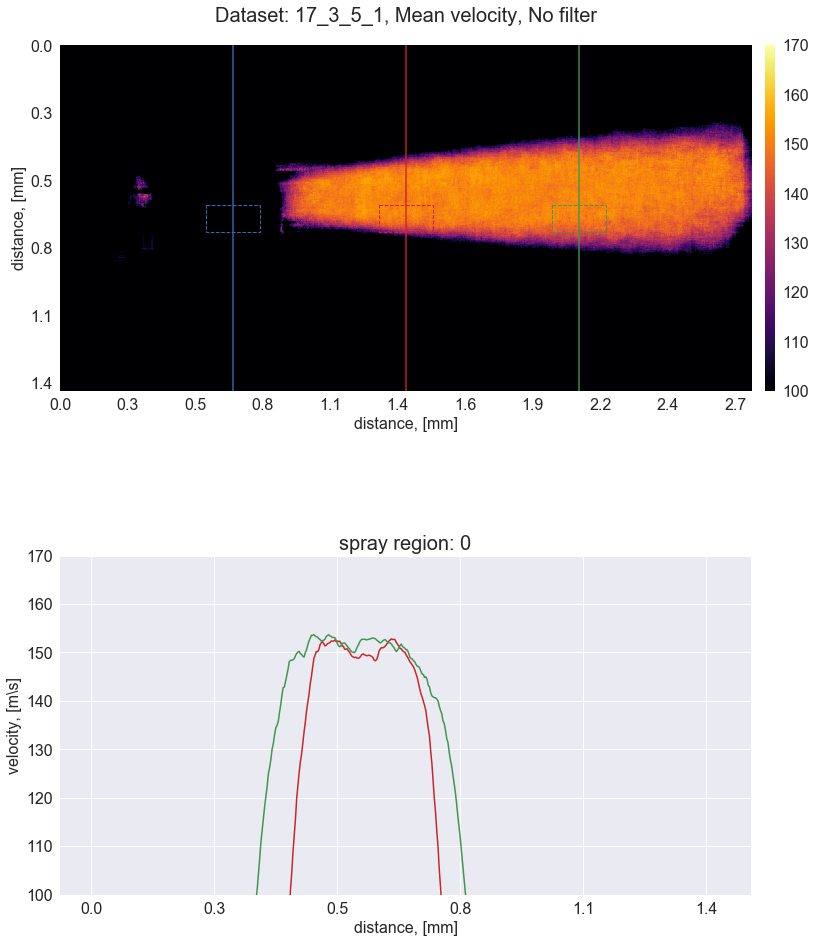

In [71]:
plot_velocity_map = True
plot_profiles = True
plot_time_evolution = False

make_analysis_figure(nofilter, 'Mean velocity, No filter', 'amp_mean_nofilter')
#make_analysis_figure(corr_filter, 'Mean velocity, Correlation filter', 'amp_mean_filter_corr')
#make_analysis_figure(amp_filter, 'Mean velocity, Velocity filter', 'amp_mean_filter_amp')
#make_analysis_figure(peak_filter, 'Mean velocity, Peak filter', 'amp_mean_filter_peak')#
#make_analysis_figure(all_filter, 'Mean velocity, All filters', 'amp_mean_filter_all')

In [112]:
dataset = '17_3_7_3'

reg_num = 4
region = regions[reg_num]

path_input = 'y:\\projects\\pn-reduction\\2018_09_esrf_me1516\\Phantom\\' + dataset + '\\' + dataset + '_Tile_d' +region + '\\'
#path_input = 'y:\\projects\\pn-reduction\\2018_09_esrf_me1516\\Phantom\\test\\' + dataset + '_Tile_d' +region + '\\'
results_path = path_input

amp_filtered = np.array(Image.open(results_path + dataset + '_Tile_d' +region + '_amp_mean_filter.tif'))


In [98]:
pd.set_option('display.width', 1000)

# Patch size for measurement
px = 5
py = 5

step_in_mm = 0.1
step_in_pixels = int(step_in_mm * 1000 / pixel_size)
print(step_in_pixels)
    
n = 9

vert_values = ['y:{0:.1f}mm'.format(x*step_in_pixels*pixel_size /1000) for x in np.arange(-(n-1)/2, (n-1)/2+1)]
columns = ['Dataset', 'Tile', 'Dist'] + vert_values
df = pd.DataFrame(columns=columns )


37


NameError: name 'amp_filtered' is not defined

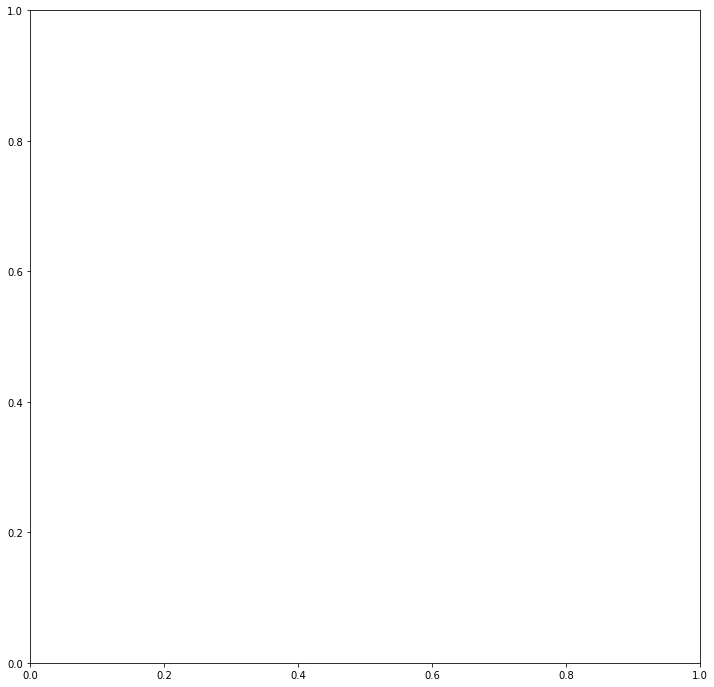

In [24]:
fig = plt.figure(1)
fig.set_size_inches(12, 12, forward=True)

ax = plt.subplot(111)

ax.imshow(amp_filtered, vmin=vel_min, vmax=vel_max, cmap='inferno')
ax.grid(False)

if reg_num == 0:
    last_pos = -step_in_mm
        
last_pos = summarize_velocity_profiles(amp_filtered, df, ax, last_pos, n)
plt.show()



In [119]:
p = 'y:\\projects\\pn-reduction\\2018_09_esrf_me1516\\Phantom\\' + dataset + '\\' + dataset + '_results_all_regions.xlsx' 
print(p)
df.to_excel(p, sheet_name='Results')

y:\projects\pn-reduction\2018_09_esrf_me1516\Phantom\17_3_7_3\17_3_7_3_results_all_regions.xlsx


In [17]:
v = df['y:0.0mm'].values.astype(np.float)
x = df['Dist'].values.astype(np.float)


plt.plot(x, v)
plt.ylim(50, 170)
plt.show()

NameError: name 'df' is not defined

## Testing

In [97]:
def test_averaging_methods_correlation(): 
    
    #------------------------------------------------
    # Filtering according to physical contraints
    #------------------------------------------------
    
    width = 512
    height = 256
    
    cx = int(width / 2) 
    cy = int(height / 2)
    
    min_vel_in_pixels = 0
    max_vel_in_pixels = 20
    
    filtered_amp = np.where(np.all([images > min_vel_in_pixels, images < max_vel_in_pixels], axis=0), images, 0)
    amp_filtered_mean = np.apply_along_axis(avg_nonzero, 0, filtered_amp)
    im_res = Image.fromarray(amp_filtered_mean*vel_factor)
    im_res.save(results_path + 'test_amp_mean_filter.tif')
    
    print(np.mean(amp_filtered_mean[cy-ry:cy+ry,cx-rx:cx+rx]*vel_factor))
    
    
    c_list = np.arange(0, 0.4, 0.02)
    res = []
    
    for c in tqdm(c_list):
            
        filtered_corr = np.where(corr > c, 1, 0)
        filtered_amp2 = filtered_amp*filtered_corr
        amp_filtered_mean = np.apply_along_axis(avg_nonzero, 0, filtered_amp2)

        #im_res = Image.fromarray(amp_filtered_mean*vel_factor)
        #im_res.save(results_path + 'test_amp_mean_filter_corr.tif')

        mean_vel_in_center = np.mean(amp_filtered_mean[cy-ry:cy+ry,cx-rx:cx+rx]*vel_factor)
        
        res.append(mean_vel_in_center)
        
        #print(mean_vel_in_center)
    
    plt.plot(c_list, res)
    plt.title('No magnitude filtering, Minimal valid correlation')
    plt.xlabel('Correlation coefficient')
    plt.ylabel('Velocity, m/s')
    plt.show()
    
    print(res)
    #data_amp = amp_filtered_mean*vel_factor
    
    #plt.hist(data_amp.flatten())
    #plt.show()

In [14]:
def test_averaging_methods_min_max(): 
    
    #------------------------------------------------
    # Filtering according to physical contraints
    #------------------------------------------------
    
    width = 1024
    height = 512
    
    cx = int(width / 2) 
    cy = int(height / 2)
    
    amp_mean = np.mean(images, axis=0)
    amp_mean_value = np.mean(amp_mean[cy-ry:cy+ry,cx-rx:cx+rx])
    print('Mean unfiltered:', amp_mean_value*vel_factor)
    
    filtered_corr = np.where(corr > min_corr_value, 1, 0)
    
    #amp_median = np.median(images, axis=0)
    #print('Median unfiltered:', np.mean(amp_median[cy-ry:cy+ry,cx-rx:cx+rx]*vel_factor))
    
    # Make outliers filtering
    min_vel_in_pixels = (1.0 - 0.5)*amp_mean_value
    max_vel_in_pixels = (1.0 + 0.5)*amp_mean_value
    
    print('Velocity outliers:', min_vel_in_pixels*vel_factor, max_vel_in_pixels*vel_factor)

    filtered_amp = np.where(np.all([images > min_vel_in_pixels, images < max_vel_in_pixels], axis=0), images, 0)
    amp_filtered_mean = np.apply_along_axis(avg_nonzero, 0, filtered_amp)
    amp_mean_filtered_value = np.mean(amp_filtered_mean[cy-ry:cy+ry,cx-rx:cx+rx])
    print('Mean 50% outliers filtered:', amp_mean_filtered_value*vel_factor)
    
    amp_filtered_mean = np.apply_along_axis(avg_nonzero, 0, filtered_amp*filtered_corr)
    amp_mean_filtered_value = np.mean(amp_filtered_mean[cy-ry:cy+ry,cx-rx:cx+rx])
    print('Mean 50% outliers filtered, correlation filtered:', amp_mean_filtered_value*vel_factor)
    
      
    perc = np.arange(0.1, 0.7, 0.05)
    #perc = np.array([0.1, 0.25, 0.5])
    
    res_unfiltered = []
    res_filtered = []
    
    for p in tqdm(perc):
    
        min_vel_in_pixels = (1.0 - p)*amp_mean_value
        max_vel_in_pixels = (1.0 + p)*amp_mean_value
    
        filtered_amp = np.where(np.all([images > min_vel_in_pixels, images < max_vel_in_pixels], axis=0), images, 0)
        amp_filtered_mean = np.apply_along_axis(avg_nonzero, 0, filtered_amp*filtered_corr)
        mean_vel_in_center = np.mean(amp_filtered_mean[cy-ry:cy+ry,cx-rx:cx+rx]*vel_factor)
    
        res_unfiltered.append(mean_vel_in_center)
        
        min_vel_in_pixels = (1.0 - p)*amp_mean_filtered_value
        max_vel_in_pixels = (1.0 + p)*amp_mean_filtered_value
    
        filtered_amp = np.where(np.all([images > min_vel_in_pixels, images < max_vel_in_pixels], axis=0), images, 0)
        amp_filtered_mean = np.apply_along_axis(avg_nonzero, 0, filtered_amp*filtered_corr)
        mean_vel_in_center = np.mean(amp_filtered_mean[cy-ry:cy+ry,cx-rx:cx+rx]*vel_factor)
    
        res_filtered.append(mean_vel_in_center)
    
    return res_unfiltered, res_filtered
    
    #print(res)
    #data_amp = amp_filtered_mean*vel_factor
    
    #plt.hist(data_amp.flatten())
    #plt.show()

In [7]:
test_averaging_methods_correlation()



NameError: name 'test_averaging_methods_correlation' is not defined

In [58]:
res_unfiltered, res_filtered = test_averaging_methods_min_max()

Mean unfiltered: 133.0679785121571
Velocity outliers: 66.53398925607856 199.60196776823568
Mean 50% outliers filtered: 142.6377735354684
Mean 50% outliers filtered, correlation filtered: 141.5551656627158


100%|██████████████████████████████████████████| 12/12 [06:59<00:00, 35.35s/it]


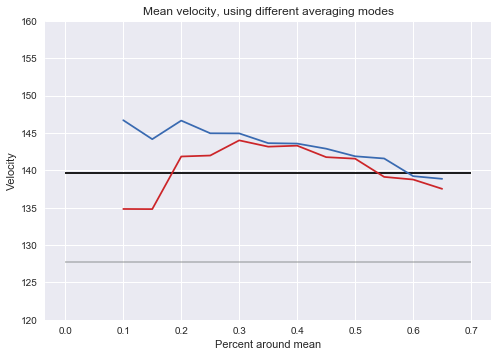

In [59]:
#print(res)

plt.style.use('seaborn')

perc = np.arange(0.1, 0.7, 0.05)

plt.plot(perc, res_unfiltered, color=red)
plt.plot(perc, res_filtered, color=blue)
plt.hlines(127.76, 0, 0.7, color=grey, alpha=0.5)
plt.hlines(139.6, 0, 0.7, color='black')
plt.title('Mean velocity, using different averaging modes')
plt.xlabel('Percent around mean')
plt.ylabel('Velocity')
plt.ylim(120, 160)
plt.savefig('y:\\projects\\pn-reduction\\2018_09_esrf_me1516\\Phantom\\' + dataset + '\\' + dataset + '_d7.5_vel_filtering_fig.png')
plt.show()


In [16]:
print(11*1.5)
print(11*0.5)

16.5
5.5


## Processing: All datasets

Processing dataset:  17_3_5_1

Processing region: 0
Reading data...
Time elapsed:  3.670036554336548
Summarizing data...
mean: 149.53872182152492
corr>0.2: 151.60705262083397
amp +/- 50%: 152.6208433237943
peak: 156.57929778808466
all: 156.57310840586175
Making figures...
Done

Processing region: 2.5
Reading data...
Time elapsed:  3.4700348377227783
Summarizing data...
mean: 147.41593382575297
corr>0.2: 150.3292975741679
amp +/- 50%: 151.88631794669413
peak: 154.98384829966346
all: 154.98384829966346
Making figures...
Done

Processing region: 5
Reading data...
Time elapsed:  3.3800337314605713
Summarizing data...
mean: 145.47710635445338
corr>0.2: 147.65673254690137
amp +/- 50%: 150.80943053418943
peak: 155.51154452337474
all: 155.44279683480366
Making figures...
Done
Finished and Saved


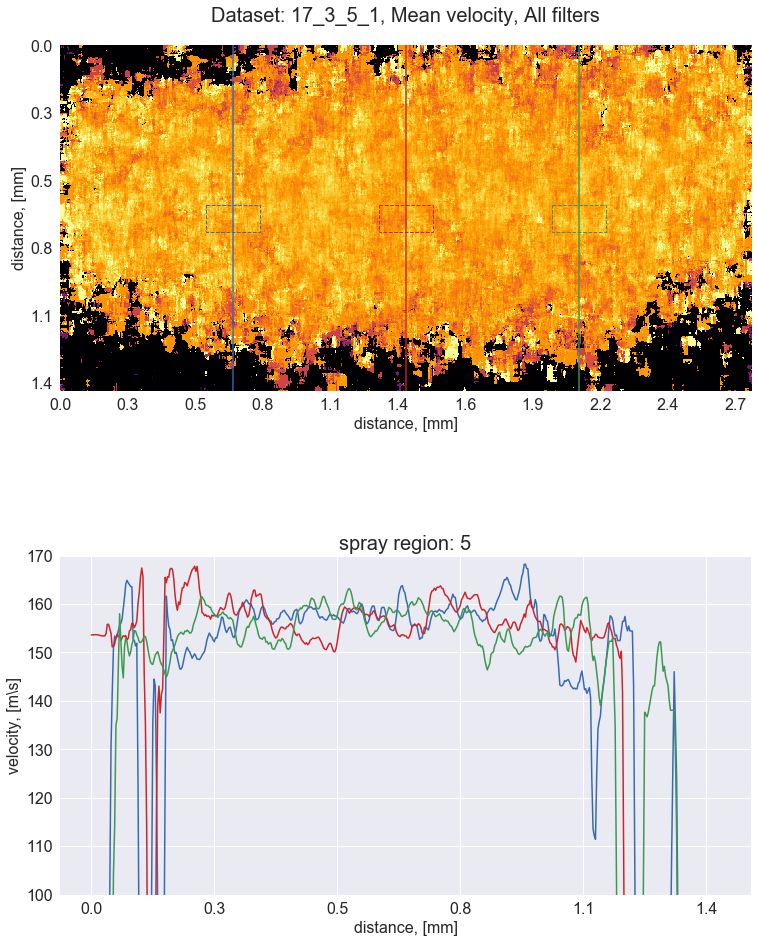

In [94]:

path = 'y:\\projects\\pn-reduction\\2018_09_esrf_me1516\\Phantom\\'
    
all_data_frames = []

#datasets = ['17_3_5_1', '17_3_7_3','17_3_23_1']
#regions = ['0', '2.5', '5', '7.5', '10', '12.5', '15', '17.5', '20']

datasets = ['17_3_5_1']
regions = ['0', '2.5', '5']


pd.set_option('display.width', 1000)

#------------------------------------
# Settings for vertical profiles 
#------------------------------------
# Patch size for measurement
px = 5
py = 5
step_in_mm = 0.1
step_in_pixels = int(step_in_mm * 1000 / pixel_size)
n = 11 # Number of vertical regions to measure


for ds in datasets:
    
    dataset = ds
    
    print('=====================================')
    print('Processing dataset: ', ds)
    print('=====================================')

    # Create an empty data frame
    vert_values = ['y:{0:.1f}mm'.format(x*step_in_pixels*pixel_size /1000) for x in np.arange(-(n-1)/2, (n-1)/2+1)]
    columns = ['Dataset', 'Tile', 'Dist', 'Filter'] + vert_values
    df = pd.DataFrame(columns=columns )

    for r in regions:

        region = r

        print('\nProcessing region:', r)

        path_input = path + dataset + '\\' + dataset + '_Tile_d' +region + '\\'
        #path_input = 'y:\\projects\\pn-reduction\\2018_09_esrf_me1516\\Phantom\\test\\' + dataset + '_Tile_d' +region + '\\'
        results_path = path_input
        file_name = dataset + '_Tile_d' +region+'.tif'
 
        print ('Reading data...')
        start = time.time()    
     
        images = read_tiff(path_input + dataset + '_Tile_d' +region +'_amp_seq.tif', max_read_images)
        corr   = read_tiff(path_input + dataset + '_Tile_d' +region + '_corr_seq.tif', max_read_images)
        peak   = read_tiff(path_input + dataset + '_Tile_d' +region + '_peak_seq.tif', max_read_images)
        flow_x   = read_tiff(path_input + dataset + '_Tile_d' +region + '_flow_x_seq.tif', max_read_images)
        flow_y   = read_tiff(path_input + dataset + '_Tile_d' +region + '_flow_y_seq.tif', max_read_images)

        end = time.time()
        print ('Time elapsed: ', (end-start))

        plot_velocity_map = True
        plot_profiles = True
        plot_time_evolution = False
        
        print ('Summarizing data...')
        nofilter, corr_filter, amp_filter, peak_filter, all_filter = filter_and_summarize_velocities(images, corr, peak, flow_x, flow_y)
        
        print ('Making figures...')
        make_analysis_figure(nofilter, 'Mean velocity, No filter', 'amp_mean_nofilter')
        make_analysis_figure(corr_filter, 'Mean velocity, Correlation filter', 'amp_mean_filter_corr')
        make_analysis_figure(amp_filter, 'Mean velocity, Velocity filter', 'amp_mean_filter_amp')
        make_analysis_figure(peak_filter, 'Mean velocity, Peak filter', 'amp_mean_filter_peak')
        make_analysis_figure(all_filter, 'Mean velocity, All filters', 'amp_mean_filter_all')

        measures_list = [(nofilter, 'no'),
                   (corr_filter, 'corr'),
                   (amp_filter, 'amp'),
                   (peak_filter, 'peak'),
                   (all_filter, 'all')]
                    
        reg_num = regions.index(r)
        if reg_num == 0:
            last_pos = -step_in_mm

        # Measure velocity profiles
        last_pos = summarize_velocity_profiles(measures_list, df, last_pos, n)

        print('Done')


    all_data_frames.append(df)

    p = path + dataset + '\\' 
    df.to_excel(p + dataset + '_results_all_regions.xlsx', sheet_name='Results')
    df.to_pickle(p + dataset + '_results_all_regions.pkl')
    print('Finished and Saved')

In [ ]:
#datasets = ['17_3_5_1', '17_3_7_3','17_3_18_1','17_3_23_1']

path = 'y:\\projects\\pn-reduction\\2018_09_esrf_me1516\\Phantom\\'


In [143]:
def plot_vel_timeline(df, measure, label):
    
    df = df[df.Filter == measure]
    
    #vert_profiles = ['y:0.3mm', 'y:0.2mm', 'y:0.1mm', 'y:0.0mm', 'y:-0.1mm', 'y:-0.2mm', 'y:-0.3mm']    
    vert_profiles = ['y:0.0mm', 'y:-0.1mm', 'y:-0.2mm'] 
    #vert_profiles = ['y:0.0mm', 'y:-0.1mm', 'y:-0.2mm']
    
    avg_res = []
    
    for v in vert_profiles:      
        vals = df[v].values.astype(np.float)
        avg_res.append(vals) 

    x = df['Dist'].values.astype(np.float)

    v = np.mean(avg_res, axis=0)

    plt.plot(x,v, label= label + ' ' + measure)

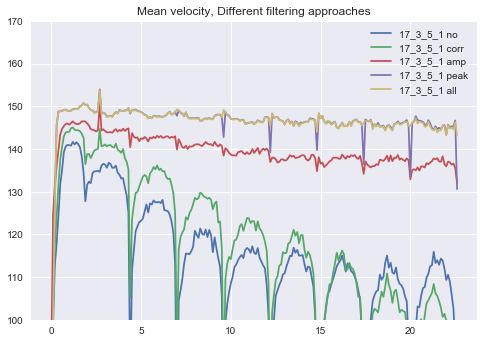

In [144]:
i = 0

datasets = ['17_3_5_1']

for d in datasets:
    p = path + d + '\\'
    df = pd.read_excel(p + d + '_results_all_regions.xlsx')
    
    
    plot_vel_timeline(df, 'no', d)
    plot_vel_timeline(df, 'corr', d)
    plot_vel_timeline(df, 'amp', d)    
    plot_vel_timeline(df, 'peak', d)
    plot_vel_timeline(df, 'all', d)

    plt.ylim(100, 170)
    i = i+1
        
plt.legend()
plt.title('Mean velocity, Different filtering approaches')
plt.show()      

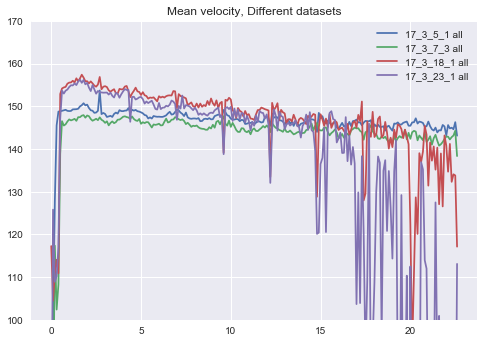

In [145]:
i = 0

datasets = ['17_3_5_1', '17_3_7_3', '17_3_18_1', '17_3_23_1']

datasets = datasets[:]

for d in datasets:
    p = path + d + '\\'
    df = pd.read_excel(p + d + '_results_all_regions.xlsx')
    
    plot_vel_timeline(df, 'all', d)

    plt.ylim(100, 170)
    i = i+1
        
plt.legend()
plt.title('Mean velocity, Different datasets')
plt.show()  

In [89]:
# Shift for 1mm in pixels

In [136]:
real = 1000 / 387
print('Estimated pixel size:',real)

Estimated pixel size: 2.5839793281653747


In [137]:
print('Difference estimated/theoretical:', real / 2.7)


Difference estimated/theoretical: 0.9570293808019905


In [139]:
145 * 0.95

137.75

In [40]:
1025 * pixel_size

2767.5

In [51]:
2306 - 2240

66

In [43]:
start_indexes = np.arange(66,3300, 220)
end_indexes   = start_indexes + 80

In [44]:
print(start_indexes)
print(end_indexes)

[  66  286  506  726  946 1166 1386 1606 1826 2046 2266 2486 2706 2926
 3146]
[ 146  366  586  806 1026 1246 1466 1686 1906 2126 2346 2566 2786 3006
 3226]


In [49]:
s = np.array([66, 290, 514, 738, 962, 1186, 1410, 1634, 1858, 2082, 2307])
e = np.array([160, 383, 607, 831, 1056, 1280, 1503, 1727, 1951, 2175, 2400])

print('Start dist:', s[1:] - s[:-1])
print('End dist:', e[1:] - e[:-1])

Start dist: [224 224 224 224 224 224 224 224 224 225]
End dist: [223 224 224 225 224 223 224 224 224 225]


In [50]:
print('Duration:', e - s)

Duration: [94 93 93 93 94 94 93 93 93 93 93]


In [56]:
print(s.tolist().index(290))

1


In [26]:
2.7 * 1024 / 1000

2.7648

In [26]:
0.1 * 2.7 * 1000

270.0

In [27]:
100 / 2.7

37.03703703703704

In [10]:
columns = ['d', 'values']
df = pd.DataFrame(columns=columns)

res = ['x', 56.125324]
df.loc[len(df)] = res

In [22]:
10*vel_factor

153.40909090909093

In [27]:
len(images)

700

In [21]:
start = time.time()
filtered_mean3 = avg_non_zero_full(filtered)
print('Elapsed:', time.time() - start)

print(np.mean(filtered_mean3))


Elapsed: 6.440073490142822
0.9997215270996094
